<a href="https://colab.research.google.com/github/MauGutierrez/Master-AI/blob/main/Deep-Learning/Proyecto_programacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=601178ae6d22291d4248f822b9ab5d26f3feb405b41b72fa313909b8cb6de806
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


## **Carga del conjunto de datos**

In [ ]:
from google.colab import files
import shutil
import zipfile
import os

# Función helper para conectarnos a Kaggle, descargar el dataset y guardarlo en una carpeta local
def download_data_to_local(): 
  # cargamos JSON de kaggle
  if os.path.exists("/content/kaggle.json"):
    print("Kaggle file already uploaded")
  else:
    uploaded = files.upload()

  # Creamos directorio para guardar JSON de kaggle
  if os.path.exists("/root/.kaggle"):
    print("Kaggle folder already exists")
  else:
    os.mkdir("/root/.kaggle")
  
  if os.path.exists("/root/.kaggle/kaggle.json"):
    print("JSON file already exists")
  else:
    shutil.copyfile("/content/kaggle.json", "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 600) 

  # Descargamos dataset correspondiente usando la API de kaggle
  if os.path.exists("/content/cassava-leaf-disease-classification.zip"):
    print("Dataset is already downloaded")
  else:
    !kaggle competitions download -c cassava-leaf-disease-classification
    print('Descargando')

  # Creamos directorio para almacenar dataset
  if os.path.exists("/content/my_dataset"):
    print("Folder to store dataset already exists")
  else:
    os.mkdir("/content/my_dataset")

  # Movemos el dataset y  lo descomprimimos en el folder my_dataset
  if os.path.exists("/content/my_dataset/train_tfrecords"):
    print("Dataset is already placed on my_dataset folder")
  else:
    with zipfile.ZipFile("/content/cassava-leaf-disease-classification.zip", 'r') as zip_ref:
      zip_ref.extractall("/content/my_dataset")

In [ ]:
download_data_to_local()

Saving kaggle.json to kaggle.json
100% 5.75G/5.76G [00:55<00:00, 119MB/s]
100% 5.76G/5.76G [00:55<00:00, 111MB/s]
Descargando


## **Inspección del conjunto de datos**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Mostramos el contenido del dataset
df = pd.read_csv('/content/my_dataset/train.csv')
print(df.head(5))

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


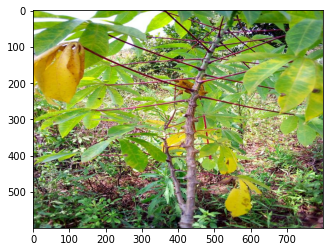

In [ ]:
import random, os

# Tomamos una imagen random del conjunto de entrenamiento y la mostramos
path = r"/content/my_dataset/train_images/"
random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])

img = cv2.imread('/content/my_dataset/train_images/' + random_filename, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## **Acondicionamiento del conjunto de datos**

In [ ]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size, target_size, preprocess):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.target_size = target_size
        self.preprocess = preprocess

    def __len__(self):
        l = int(len(self.X) / self.batch_size)
        if l*self.batch_size < len(self.X):
            l += 1
        return l

    def __get_data(self, data):
      X = []
      for name in data:
        img_path = os.path.join('/content/my_dataset/train_images', name)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(self.target_size, self.target_size))
        image = tf.keras.utils.img_to_array(image)

        if self.preprocess is None:
          X.append(image/255.)
        else:
          X.append(self.preprocess(image))
      
      return X

    def __getitem__(self, index):
        X = self.X[index*self.batch_size:(index+1)*self.batch_size]
        y = np.array(self.y[index*self.batch_size:(index+1)*self.batch_size])
        X = np.array(self.__get_data(X))
        return X, y

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Esta función devuelve en X_train y X_val los NOMBRES de las imágenes, posteriormente deberán ser cargadas por batch para el entrenamiento
# Además regresa X_test que será utilizado para la posterior evaluación del modelo ya entrenado
def read_dataset(path_csv, test_split, val_split, shuffle):
    dataframe = pd.read_csv(path_csv)
    images = np.array(dataframe['image_id'])
    labels = np.array(dataframe['label'])
    labels_categorical = to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=test_split, random_state=42 ,shuffle=shuffle)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42, shuffle=shuffle)

    print('Carga de datos realizada con éxito\n')
    print(f'Se han encontrado {len(x_train)} imágenes para TRAIN, {len(x_val)} imágenes para validación y {len(x_test)} imágenes para TEST')
    print(f'La base de datos contiene {len(np.unique(labels))} clases')
    return x_train,x_val,x_test,y_train,y_val,y_test


X_train, X_val, X_test, y_train, y_val, y_test = read_dataset('/content/my_dataset/train.csv', test_split=0.2, val_split=0.2, shuffle=True)

Carga de datos realizada con éxito

Se han encontrado 13693 imágenes para TRAIN, 3424 imágenes para validación y 4280 imágenes para TEST
La base de datos contiene 5 clases


## **Desarrollo de arquitectura de red neuronal** - Estrategia from scratch

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.constraints import unit_norm

def define_model(n_classes, target_size):
	model = keras.Sequential()
	model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(target_size, target_size, 3)))
	model.add(MaxPooling2D(pool_size=(2, 2)))
 
	model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	
	model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	
	model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# Capa de flatten
	model.add(Flatten())
	model.add(Dropout(0.50))
	model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))

	# Capa de salida
	model.add(Dense(n_classes, activation='softmax'))
 
	# compile model
	opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
import os

# Función helper que será utilizada para guardar el modelo una vez que ya ha sido entrenado
# Recibe como parámetros el modelo entrenado, el nombre que le pondremos al modelo y la ruta donde guardaremos el modelo
def save_model(model, model_name, ruta):
  model_json = model.to_json()
  with open(os.path.join(ruta, str(model_name) + ".json"), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(os.path.join(ruta, str(model_name) + ".h5"))
  print("Saved model to disk")

In [ ]:
# Función helper para evaluar el modelo entrenado
# Recibe como parametros el modelo entrenado, el data generator que cargara por batches los datos de test y el tamaño del batch
def evaluate_model(model, test_generator, batch_size):   
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print("Evaluate on test data")
  results = model.evaluate(test_generator, batch_size=batch_size)
  print("test loss, test acc:", results)

In [ ]:
# Tamaño de las imagenes a usar
target_size = 256

# Definimos el modelo
model = define_model(n_classes=5, target_size=target_size)

# Summary del modelo
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)        

## **Entrenamiento de la solución** - Estrategia from scratch

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Tamaño de batch que usaremos
batch_size = 128

# Tamaño de las imagenes a usar
target_size = 256

# Numero de epochs para el entrenamiento
nb_epochs = 20

# Definimos el modelo
model = define_model(n_classes=5, target_size=target_size)


#Entrenamiento
train_model=model.fit(
    DataGenerator(X_train, y_train, batch_size, target_size, None),
    validation_data = DataGenerator(X_val, y_val, batch_size, target_size, None),
    epochs = nb_epochs
)


Epoch 1/20
107/107 [==============================] - 127s 1s/step - loss: 1.1765 - accuracy: 0.6108 - val_loss: 1.1252 - val_accuracy: 0.6089
Epoch 2/20
107/107 [==============================] - 127s 1s/step - loss: 1.0677 - accuracy: 0.6241 - val_loss: 1.0233 - val_accuracy: 0.6259
Epoch 3/20
107/107 [==============================] - 127s 1s/step - loss: 1.0097 - accuracy: 0.6345 - val_loss: 0.9892 - val_accuracy: 0.6367
Epoch 4/20
107/107 [==============================] - 127s 1s/step - loss: 0.9881 - accuracy: 0.6397 - val_loss: 0.9594 - val_accuracy: 0.6416
Epoch 5/20
107/107 [==============================] - 127s 1s/step - loss: 0.9660 - accuracy: 0.6432 - val_loss: 0.9724 - val_accuracy: 0.6349
Epoch 6/20
107/107 [==============================] - 127s 1s/step - loss: 0.9578 - accuracy: 0.6468 - val_loss: 0.9316 - val_accuracy: 0.6507
Epoch 7/20
107/107 [==============================] - 127s 1s/step - loss: 0.9461 - accuracy: 0.6527 - val_loss: 0.9246 - val_accuracy: 0.6583

## **Monitorización del proceso de entrenamiento** - Estrategia from Scratch

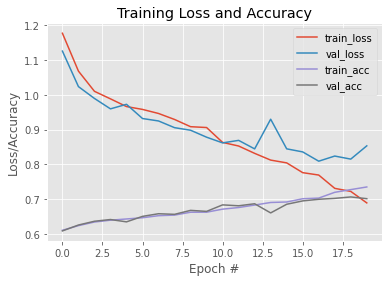

In [ ]:
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, nb_epochs), train_model.history["loss"], label="train_loss")
plt.plot(np.arange(0, nb_epochs), train_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, nb_epochs), train_model.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, nb_epochs), train_model.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Guardamos el modelo entrenado
save_model(model, "proyecto_deep_learning_base", "/content")

Saved model to disk


## **Evaluación del modelo** - Estrategia from scratch

In [ ]:
# Evaluamos el modelo entrenado

evaluate_model(model, DataGenerator(X_test, y_test, batch_size, target_size=target_size, None), batch_size)

Evaluate on test data
34/34 [==============================] - 32s 931ms/step - loss: 0.8527 - accuracy: 0.6928
test loss, test acc: [0.8526604771614075, 0.6927570104598999]


**Estrategia 2**

Transfer learning



In [ ]:
#Función que permite cargar el base model

def load_pretained_model(base_model, dim=(target_size, target_size), n_channels=3, n_classes=5, learning_rate=0.001, plot_model_summary=True, beta_1=0.9, beta_2=0.999, epsilon=1e-08):

    #Base model
    base_model = base_model(
        include_top=False,
        pooling='max',  # max or avg pooling,
        weights='imagenet',
        input_shape=dim + (n_channels,),
    )

    # Congelamos el modelo base para que no se entrenen los pesos
    # y así utilizar los pesos w previamente ya entrenados
    base_model.trainable = False

    # Capa de flatten
    model = base_model.layers[-1].output
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dropout(0.5)(model)

    # Parte Densa añadida manualmente 
    model = tf.keras.layers.Dense(64, kernel_regularizer=l2(0.0001))(model)
    model = tf.keras.layers.ReLU()(model)

    model = tf.keras.layers.Dense(n_classes, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=model, name=base_model.name)

    if(plot_model_summary):
      model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon),
        metrics=['accuracy']
    )

    return model

In [ ]:
from tensorflow.keras.applications import ResNet50V2, VGG16, Xception, InceptionResNetV2
import tensorflow as tf

# Tamaño de las imagenes a usar
dimension = (256, 256)

#Carga de los distintos modelos preentrenados a evaluar. Se cargan ya compilados
model_ResNet50V2 = load_pretained_model(ResNet50V2, dim=dimension, plot_model_summary=False)
model_VGG16 = load_pretained_model(VGG16, dim=dimension, plot_model_summary=False)
model_Xception = load_pretained_model(Xception, dim=dimension, plot_model_summary=False)
model_InceptionResNetV2 = load_pretained_model(InceptionResNetV2, dim=dimension, plot_model_summary=False)

In [ ]:
import matplotlib.pyplot as plt

#Definimos la función que lleva a cabo el entrenamiento de cada modelo, para simplificar el código
#Recibe los datos de entrada, el modelo a entrenar, batch_size y número de epocas.
def entrenamiento_modelos(X_train, y_train, X_val, y_val, model, preprocess, path_images_train, path_images_val, target_size, batch_size, nb_epochs):
  #Entrenamiento
  train_model=model.fit(
    DataGenerator(X_train, y_train, batch_size, target_size, preprocess),
    validation_data = DataGenerator(X_val, y_val, batch_size, target_size, preprocess),
    epochs = nb_epochs
  )


  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, nb_epochs), train_model.history["loss"], label="train_loss")
  plt.plot(np.arange(0, nb_epochs), train_model.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, nb_epochs), train_model.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, nb_epochs), train_model.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Epoch 1/20
107/107 [==============================] - 132s 1s/step - loss: 1.8389 - accuracy: 0.5780 - val_loss: 0.9915 - val_accuracy: 0.6089
Epoch 2/20
107/107 [==============================] - 128s 1s/step - loss: 1.0035 - accuracy: 0.6287 - val_loss: 0.9465 - val_accuracy: 0.6463
Epoch 3/20
107/107 [==============================] - 129s 1s/step - loss: 0.9678 - accuracy: 0.6460 - val_loss: 0.9173 - val_accuracy: 0.6533
Epoch 4/20
107/107 [==============================] - 128s 1s/step - loss: 0.9385 - accuracy: 0.6527 - val_loss: 0.9039 - val_accuracy: 0.6539
Epoch 5/20
107/107 [==============================] - 128s 1s/step - loss: 0.9194 - accuracy: 0.6590 - val_loss: 0.8814 - val_accuracy: 0.6659
Epoch 6/20
107/107 [==============================] - 128s 1s/step - loss: 0.8965 - accuracy: 0.6658 - val_loss: 0.8608 - val_accuracy: 0.6761
Epoch 7/20
107/107 [==============================] - 128s 1s/step - loss: 0.8829 - accuracy: 0.6754 - val_loss: 0.8530 - val_accuracy: 0.6758

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


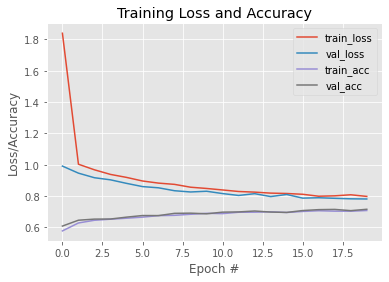

In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

#Entrenamiento del modelo ResNet50V2
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train = '/content/my_dataset/train_images'
path_images_val = '/content/my_dataset/train_images'

resnet_model = model_ResNet50V2
entrenamiento_modelos(X_train, y_train, X_val, y_val, resnet_model, preprocess_input, path_images_train, path_images_val, target_size,  batch_size, nb_epochs)
save_model(resnet_model, "proyecto_deep_learning_resnet", "/content")

Epoch 1/20
107/107 [==============================] - 161s 1s/step - loss: 12.5248 - accuracy: 0.4286 - val_loss: 1.5418 - val_accuracy: 0.5774
Epoch 2/20
107/107 [==============================] - 134s 1s/step - loss: 1.7332 - accuracy: 0.5382 - val_loss: 1.4578 - val_accuracy: 0.6089
Epoch 3/20
107/107 [==============================] - 133s 1s/step - loss: 1.3880 - accuracy: 0.5960 - val_loss: 1.1855 - val_accuracy: 0.6089
Epoch 4/20
107/107 [==============================] - 134s 1s/step - loss: 1.2107 - accuracy: 0.6065 - val_loss: 1.0636 - val_accuracy: 0.6089
Epoch 5/20
107/107 [==============================] - 134s 1s/step - loss: 1.1375 - accuracy: 0.6093 - val_loss: 1.0249 - val_accuracy: 0.6089
Epoch 6/20
107/107 [==============================] - 134s 1s/step - loss: 1.0968 - accuracy: 0.6102 - val_loss: 1.0001 - val_accuracy: 0.6089
Epoch 7/20
107/107 [==============================] - 134s 1s/step - loss: 1.0713 - accuracy: 0.6115 - val_loss: 0.9855 - val_accuracy: 0.608

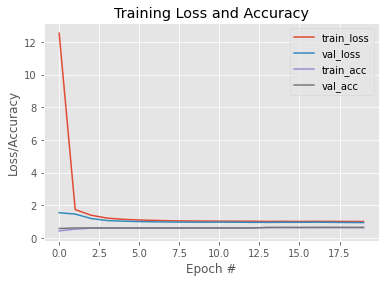

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

#Entrenamiento del modelo VGG16
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train='/content/my_dataset/train_images'
path_images_val='/content/my_dataset/train_images'

vgg_model = model_VGG16
entrenamiento_modelos(X_train, y_train, X_val, y_val, vgg_model, preprocess_input, path_images_train, path_images_val, target_size, batch_size, nb_epochs)
save_model(vgg_model, "proyecto_deep_learning_vgg", "/content")

Epoch 1/20
107/107 [==============================] - 137s 1s/step - loss: 1.1185 - accuracy: 0.6205 - val_loss: 0.9082 - val_accuracy: 0.6726
Epoch 2/20
107/107 [==============================] - 130s 1s/step - loss: 0.9264 - accuracy: 0.6619 - val_loss: 0.8551 - val_accuracy: 0.6846
Epoch 3/20
107/107 [==============================] - 130s 1s/step - loss: 0.8890 - accuracy: 0.6741 - val_loss: 0.8423 - val_accuracy: 0.6840
Epoch 4/20
107/107 [==============================] - 130s 1s/step - loss: 0.8677 - accuracy: 0.6829 - val_loss: 0.8204 - val_accuracy: 0.6995
Epoch 5/20
107/107 [==============================] - 131s 1s/step - loss: 0.8513 - accuracy: 0.6889 - val_loss: 0.8268 - val_accuracy: 0.6995
Epoch 6/20
107/107 [==============================] - 131s 1s/step - loss: 0.8249 - accuracy: 0.6965 - val_loss: 0.8091 - val_accuracy: 0.7033
Epoch 7/20
107/107 [==============================] - 130s 1s/step - loss: 0.8241 - accuracy: 0.6981 - val_loss: 0.8094 - val_accuracy: 0.7036

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


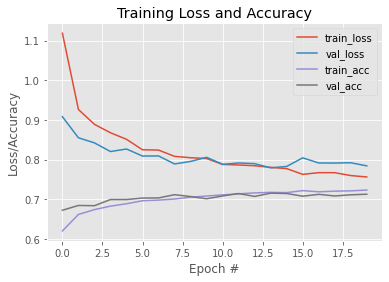

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

#Entrenamiento del modelo Xception
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train = '/content/my_dataset/train_images'
path_images_val = '/content/my_dataset/train_images'

x_model = model_Xception
entrenamiento_modelos(X_train, y_train, X_val, y_val, x_model, preprocess_input, path_images_train, path_images_val, target_size, batch_size, nb_epochs)
save_model(x_model, "proyecto_deep_learning_x", "/content")

Epoch 1/20
107/107 [==============================] - 148s 1s/step - loss: 1.3834 - accuracy: 0.5856 - val_loss: 1.0376 - val_accuracy: 0.6154
Epoch 2/20
107/107 [==============================] - 135s 1s/step - loss: 1.0587 - accuracy: 0.6231 - val_loss: 0.9907 - val_accuracy: 0.6215
Epoch 3/20
107/107 [==============================] - 137s 1s/step - loss: 1.0283 - accuracy: 0.6262 - val_loss: 0.9759 - val_accuracy: 0.6265
Epoch 4/20
107/107 [==============================] - 137s 1s/step - loss: 1.0088 - accuracy: 0.6275 - val_loss: 0.9505 - val_accuracy: 0.6285
Epoch 5/20
107/107 [==============================] - 137s 1s/step - loss: 0.9866 - accuracy: 0.6334 - val_loss: 0.9397 - val_accuracy: 0.6396
Epoch 6/20
107/107 [==============================] - 136s 1s/step - loss: 0.9736 - accuracy: 0.6363 - val_loss: 0.9550 - val_accuracy: 0.6516
Epoch 7/20
107/107 [==============================] - 136s 1s/step - loss: 0.9685 - accuracy: 0.6424 - val_loss: 0.9165 - val_accuracy: 0.6513

NameError: ignored

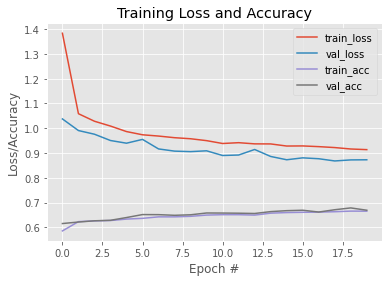

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

#Entrenamiento del modelo InceptionResNetV2
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train = '/content/my_dataset/train_images'
path_images_val = '/content/my_dataset/train_images'

inception_model = model_InceptionResNetV2
entrenamiento_modelos(X_train, y_train, X_val, y_val, inception_model, preprocess_input, path_images_train, path_images_val, target_size, batch_size, nb_epochs)
save_model(inception_model, "proyecto_deep_learning_resnet2", "/content")

## **Evaluación de métodos pre entrenados** - Transfer Learning

In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

print("Evaluación modelo ResNet50V2")
evaluate_model(resnet_model, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo ResNet50V2
Evaluate on test data
34/34 [==============================] - 34s 962ms/step - loss: 0.7743 - accuracy: 0.7168
test loss, test acc: [0.7743251919746399, 0.7168224453926086]


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

print("Evaluación modelo VGG16")
evaluate_model(vgg_model, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo VGG16
Evaluate on test data
34/34 [==============================] - 41s 1s/step - loss: 0.9321 - accuracy: 0.6551
test loss, test acc: [0.9320868253707886, 0.6551401615142822]


In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

print("Evaluación modelo Xception")
evaluate_model(x_model, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo Xception
Evaluate on test data
34/34 [==============================] - 35s 997ms/step - loss: 0.7953 - accuracy: 0.7157
test loss, test acc: [0.7952605485916138, 0.715654194355011]


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

print("Evaluación modelo InceptionResNetV2")
evaluate_model(inception_model, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo InceptionResNetV2
Evaluate on test data
34/34 [==============================] - 39s 984ms/step - loss: 0.8652 - accuracy: 0.6843
test loss, test acc: [0.8652092814445496, 0.6843457818031311]


**Fine-tunning**

In [ ]:
#Función que permite cargar el base model

def load_pretained_model_fine_tunning(base_model, inicio_trainable, dim, n_channels=3, n_classes=5, learning_rate=0.001, plot_model_summary=True, beta_1=0.9, beta_2=0.999, epsilon=1e-08):

    #Base model
    base_model = base_model(
        include_top=False,
        pooling='max',  # max or avg pooling,
        weights='imagenet',
        input_shape=dim + (n_channels,),
    )

    base_model.trainable = False

    for layer in base_model.layers[inicio_trainable:]:
	    layer.trainable = True

    # Capa de flatten
    model = base_model.layers[-1].output
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dropout(0.5)(model)

    # Parte Densa añadida manualmente 
    model = tf.keras.layers.Dense(64, kernel_regularizer=l2(0.0001))(model)
    model = tf.keras.layers.ReLU()(model)

    model = tf.keras.layers.Dense(n_classes, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=model, name=base_model.name)

    if plot_model_summary:
      print(model.summary())

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),
        metrics=['accuracy'],
    )

    return model

In [ ]:
from tensorflow.keras.applications import ResNet50V2, Xception
import tensorflow as tf

# Tamaño de las imagenes a usar
dimension = (256, 256)

capa_inicio = 1000

#Carga de los distintos modelos preentrenados a evaluar. Se cargan ya compilados
model_ResNet50V2_FT = load_pretained_model_fine_tunning(ResNet50V2, capa_inicio, dim=dimension, plot_model_summary=True)
model_Xception_FT = load_pretained_model_fine_tunning(Xception, capa_inicio, dim=dimension, plot_model_summary=True)

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
import matplotlib.pyplot as plt
#Definimos la función que lleva a cabo el entrenamiento de cada modelo, para simplificar el código
#Recibe los datos de entrada, el modelo a entrenar, batch_size y número de epocas.

def entrenamiento_modelos(X_train, y_train, X_val, y_val, model, preprocess, path_images_train, path_images_val, target_size, batch_size, nb_epochs):
  #Entrenamiento
  train_model=model.fit(
    DataGenerator(X_train, y_train, batch_size, target_size, preprocess),
    validation_data = DataGenerator(X_val, y_val, batch_size, target_size, preprocess),
    epochs = nb_epochs
  )


  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, nb_epochs), train_model.history["loss"], label="train_loss")
  plt.plot(np.arange(0, nb_epochs), train_model.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, nb_epochs), train_model.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, nb_epochs), train_model.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Epoch 1/20
107/107 [==============================] - 135s 1s/step - loss: 0.7948 - accuracy: 0.7066 - val_loss: 0.7879 - val_accuracy: 0.7114
Epoch 2/20
107/107 [==============================] - 131s 1s/step - loss: 0.7899 - accuracy: 0.7062 - val_loss: 0.7711 - val_accuracy: 0.7129
Epoch 3/20
107/107 [==============================] - 132s 1s/step - loss: 0.7801 - accuracy: 0.7154 - val_loss: 0.7663 - val_accuracy: 0.7167
Epoch 4/20
107/107 [==============================] - 133s 1s/step - loss: 0.7776 - accuracy: 0.7127 - val_loss: 0.7653 - val_accuracy: 0.7193
Epoch 5/20
107/107 [==============================] - 132s 1s/step - loss: 0.7769 - accuracy: 0.7166 - val_loss: 0.7668 - val_accuracy: 0.7217
Epoch 6/20
107/107 [==============================] - 133s 1s/step - loss: 0.7809 - accuracy: 0.7134 - val_loss: 0.7625 - val_accuracy: 0.7234
Epoch 7/20
107/107 [==============================] - 132s 1s/step - loss: 0.7742 - accuracy: 0.7140 - val_loss: 0.7795 - val_accuracy: 0.7126

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


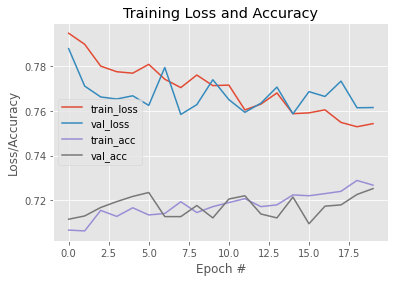

In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

#Entrenamiento del modelo ResNet50V2
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train = '/content/my_dataset/train_images'
path_images_val = '/content/my_dataset/train_images'
resnet_model_ft = model_ResNet50V2

entrenamiento_modelos(X_train, y_train, X_val, y_val, resnet_model_ft, preprocess_input, path_images_train, path_images_val, target_size,  batch_size, nb_epochs)
save_model(resnet_model_ft, "proyecto_deep_learning_resnet_ft", "/content")

Epoch 1/20
107/107 [==============================] - 139s 1s/step - loss: 1.1511 - accuracy: 0.6126 - val_loss: 0.9130 - val_accuracy: 0.6650
Epoch 2/20
107/107 [==============================] - 137s 1s/step - loss: 0.9445 - accuracy: 0.6549 - val_loss: 0.8948 - val_accuracy: 0.6770
Epoch 3/20
107/107 [==============================] - 137s 1s/step - loss: 0.8948 - accuracy: 0.6698 - val_loss: 0.8606 - val_accuracy: 0.6913
Epoch 4/20
107/107 [==============================] - 137s 1s/step - loss: 0.8720 - accuracy: 0.6802 - val_loss: 0.8333 - val_accuracy: 0.6936
Epoch 5/20
107/107 [==============================] - 136s 1s/step - loss: 0.8517 - accuracy: 0.6874 - val_loss: 0.8225 - val_accuracy: 0.6960
Epoch 6/20
107/107 [==============================] - 134s 1s/step - loss: 0.8377 - accuracy: 0.6925 - val_loss: 0.8123 - val_accuracy: 0.7015
Epoch 7/20
107/107 [==============================] - 134s 1s/step - loss: 0.8373 - accuracy: 0.6920 - val_loss: 0.8137 - val_accuracy: 0.7039

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


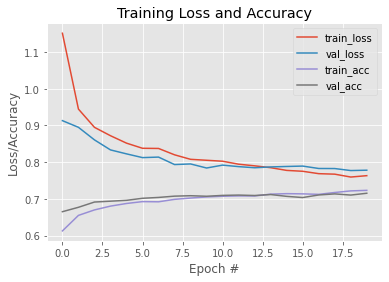

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

#Entrenamiento del modelo Xception
batch_size = 128
nb_epochs = 20
target_size = 256
path_images_train = '/content/my_dataset/train_images'
path_images_val = '/content/my_dataset/train_images'
x_model_ft = model_Xception_FT

entrenamiento_modelos(X_train, y_train, X_val, y_val, x_model_ft, preprocess_input, path_images_train, path_images_val, target_size,  batch_size, nb_epochs)
save_model(x_model_ft, "proyecto_deep_learning_x_ft", "/content")

## **Evaluación de métodos pre entrenados** - Fine Tunning

In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

print("Evaluación modelo ResNet50V2 con Fine Tunning")
evaluate_model(resnet_model_ft, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo ResNet50V2 con Fine Tunning
Evaluate on test data
34/34 [==============================] - 35s 991ms/step - loss: 0.7653 - accuracy: 0.7292
test loss, test acc: [0.7653336524963379, 0.7292056083679199]


In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

print("Evaluación modelo Xception con Fine Tunning")
evaluate_model(x_model_ft, DataGenerator(X_test, y_test, batch_size, target_size, preprocess_input), batch_size)

Evaluación modelo Xception con Fine Tunning
Evaluate on test data
34/34 [==============================] - 35s 975ms/step - loss: 0.7950 - accuracy: 0.7103
test loss, test acc: [0.7949575781822205, 0.7102803587913513]
